## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 12: Machine Learning methods for Classification

<b>Reading:</b> notes below, as well as $\S$9.3-9.7 of [Machine Learning](http://www.astroml.org/).

Last week we looked at [Gaussian Mixture](http://scikit-learn.org/stable/modules/mixture.html) modeling. It can be used to assign data points to distinct and separate classes. [**Sklearn**](http://scikit-learn.org) (or Scikit-Learn) module provides several others methods for classification:

[Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html)

[Support Vector Machines](http://scikit-learn.org/stable/modules/svm.html)

[Random Forest](http://scikit-learn.org/stable/modules/ensemble.html#forest)

A handy comparison of all different classification methods is given [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

Some examples are provided in astroML. The Gaussian Mixture classifier is in [Figure 9.1](http://www.astroml.org/book_figures/chapter9/fig_bayes_DB.html) and [Figure 9.2](http://www.astroml.org/book_figures/chapter9/fig_simple_naivebayes.html). The SVM classifier is in [Figure 9.9](http://www.astroml.org/book_figures/chapter9/fig_svm_diagram.html).

In [2]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, svm, ensemble

#### SDSS dataset

Download a large dataset of galaxies with spectroscopic information from the SDSS survey. This survey obtained images for 357,000,000 stars and galaxies in five photometric bands, as well as spectroscopy for 1,600,000 galaxies, quasars, and stars. AstroML provides access to a subset of this huge information. It is described [here](http://www.astroml.org/user_guide/datasets.html). To load the properties of galaxies from the spectroscopic dataset, execute the following cell. The output lists various fields listed in the dataset, including galaxy positions on the sky, redshift, velocity dispersion, magnitudes in the SDSS $u$, $g$, $r$, $i$, and $z$ bands, stellar mass, star formation rate, and others.

In [3]:
from astroML.datasets import fetch_sdss_specgals
from astroML.plotting import scatter_contour
from astroML.plotting.tools import draw_ellipse

data = fetch_sdss_specgals()
print data.shape, 'spectra fields:', data.dtype.names

(661598L,) spectra fields: ('ra', 'dec', 'mjd', 'plate', 'fiberID', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r', 'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID')


Let make a common color-magnitude diagram, for the $g-r$ color vs. $r$-band magnitude. To make a cleaner dataset, we restrict the redshift range to $0.02 < z < 0.06$. This reduces the number of objects from 661598 to 114527, still a huge number for a statistical study.

114527 galaxies selected


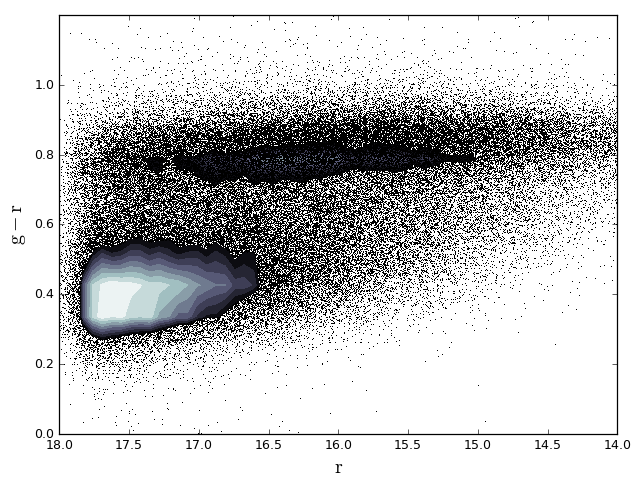

In [4]:
# redshift cut 
data = data[data['z'] > 0.02]
data = data[data['z'] < 0.06]

gr = data['modelMag_g'] - data['modelMag_r']
r = data['modelMag_r']
print len(r), 'galaxies selected'

fig, ax = plt.subplots(figsize=(8, 6))
scatter_contour(r, gr, threshold=400, log_counts=True, ax=ax,
                histogram2d_args=dict(bins=100),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

ax.set_xlabel(r'${\rm r}$', size=16)
ax.set_ylabel(r'${\rm g - r}$', size=16)
ax.set_xlim(18, 14)
ax.set_ylim(0, 1.2)
plt.show()

There is a bimodality in the color distribution. The long narrow band around $g-r = 0.8$ is called *red sequence* galaxies, while the big cloud at $0.3 < g-r < 0.5$ is the *blue cloud* (star-forming) galaxies. The histogram below confirms this bimodal distribution.

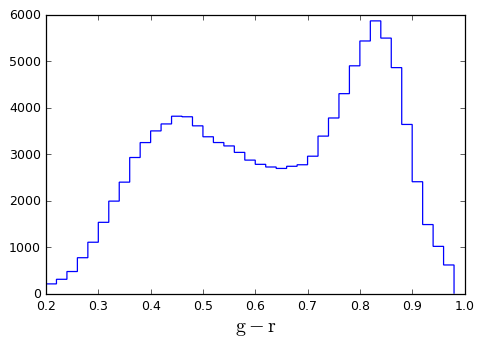

In [5]:
plt.hist(gr, bins=np.arange(0.2,1,0.02), histtype='step')
plt.xlabel(r'${\rm g - r}$', size=16)
plt.show()

However, from a much smaller dataset, it would be difficult to infer this bimodality. Let's take the first hundred galaxies and plot their color histogram:

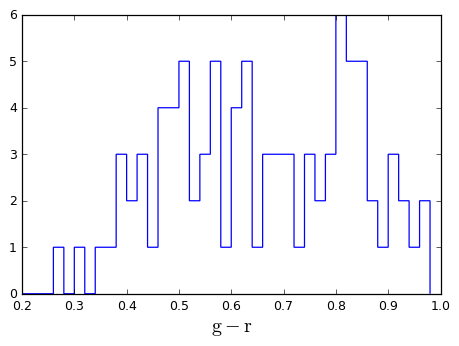

In [6]:
plt.hist(gr[:100], bins=np.arange(0.2,1,0.02), histtype='step')
plt.xlabel(r'${\rm g - r}$', size=16)
plt.show()

### Machine Learning

Machine Learning methods allow efficient exploration of datasets.  They are often divided into the categories of **Supervised** and **Unsupervised** methods.

**Supervised** methods generally deal with classification of objects. They are given a **labeled** training dataset, and the model is later applied to **un-labeled** data in order to predict the unknown label.

**Unsupervised** methods generally deal with clustering of objects or density estimation. They are given an **un-labeled** training dataset, and make inferences about the structure of the data without any label input. One familiar example is Kernel Density Estimator (KDE) which we used instead of histograms. Another example is Gaussian Mixture Modeling.

Most models in **Sklearn** have similar syntax. They are trained on a particular dataset using the ``fit()`` method. Then labels for new points can be predicted using the ``predict()`` method. This makes it very convenient to try different Machine Learning models just by changing the initialization step.

**Sklearn** also provides a routine (``cross_val_score``) for cross-validation of the model parameters, that is, evaluation of how well a particular model could be expected to perform on the dataset.

Here is an example of selecting the training set and the test set from our galaxy database. Let's take a relatively small number, 100 objects for the training set, and a larger number, 1000 objects for the training set.

In [7]:
X = np.vstack([r, gr]).T
print 'total dataset:', X.shape, 'galaxies'

Xtraining = X[:100]
print 'training set:', len(Xtraining), 'galaxies'

Xtest = X[-1000:]
print 'test set:', len(Xtest), 'galaxies'

total dataset: (114527L, 2L) galaxies
training set: 100 galaxies
test set: 1000 galaxies


Let's begin our exploration of this dataset with unsupervised Gaussian Mixture Modeling, which does not require the knowledge of any labels.

best fit converged: True
number of interations = 5
BIC: N components = 2


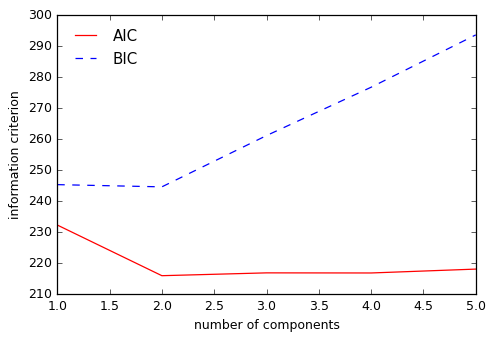

In [8]:
from sklearn.mixture import GaussianMixture

N = np.arange(1, 6)
models = [None for n in N]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i], covariance_type='full').fit(Xtraining)

AIC = [m.aic(Xtraining) for m in models]
BIC = [m.bic(Xtraining) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print 'best fit converged:', gmm_best.converged_
print 'number of interations =', gmm_best.n_iter_
print 'BIC: N components = %i' % N[i_best]

plt.plot(N, AIC, 'r-', label='AIC')
plt.plot(N, BIC, 'b--', label='BIC')
plt.xlabel('number of components')
plt.ylabel('information criterion')
plt.legend(loc=2, frameon=False)
plt.show()

Both information criteria prefer two modes. Let's color the points according to the predicted split of the training dataset.

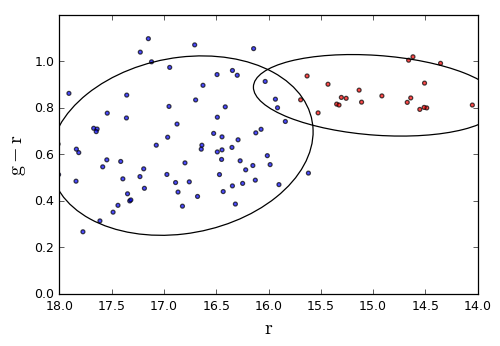

In [24]:
cmap_bold = ListedColormap(['#0000FF', '#00FF00', '#FF0000'])
cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])

gmm_best = models[1]

plt.scatter(Xtraining[:,0], Xtraining[:,1], c=gmm_best.predict(Xtraining), cmap=cmap_bold, alpha=0.7, s=10)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)

for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[2], fc='none', ec='k')

Now we can predict the expected mode for any value of $r, g-r$ and color the whole space according to the predicted mode.

[]

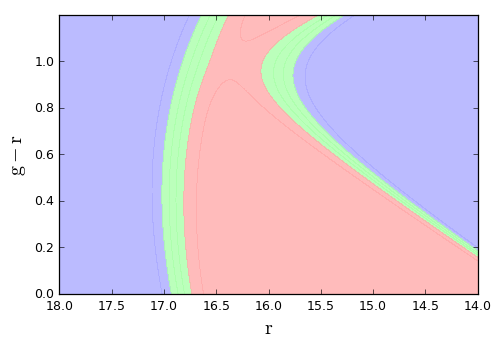

In [55]:
xx, yy = np.meshgrid(np.linspace(18,14,200), np.linspace(0,1.2,120))

Z = gmm_best.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

### Nearest Neighbors

The [Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html) method could be as supervised or unsupervised.

Let's use the supervised version and assign the training labels two values (True or False) based on whether $g-r > 0.65$, which seems like a reasonable split by eye. The algorithm should refine this estimate of the boundary between the clusters, using a larger test set.

In [28]:
border = 0.65
target = (Xtraining[:,1] > border)

Scatter plot of the training set, colored by the assigned labels.

[]

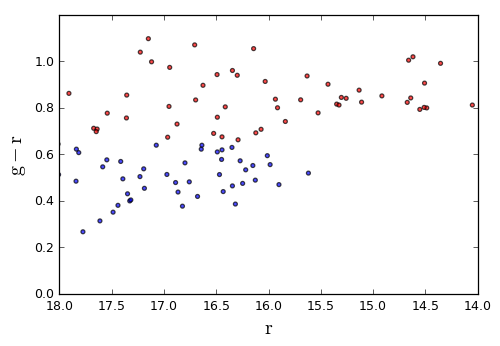

In [56]:
cmap_bold = ListedColormap(['#0000FF', '#00FF00', '#FF0000'])
cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])

plt.scatter(Xtraining[:,0], Xtraining[:,1], c=target, cmap=cmap_bold, alpha=0.7, s=10)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

Now we initialize the Sklearn's implementation of the [NN Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), evaluate fit for the training dataset, and predict labels for the test set. The most important parameters to choose are the number of neighbors and how their contributions are weighted.

[]

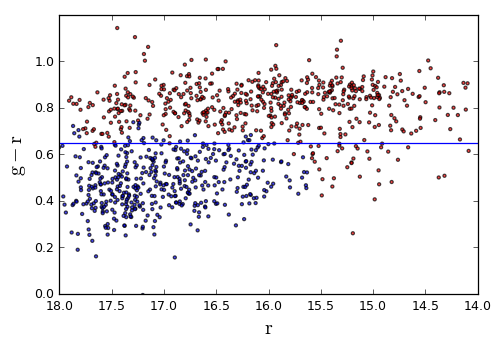

In [57]:
clf = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

Close-up view near the decision boundary.

[]

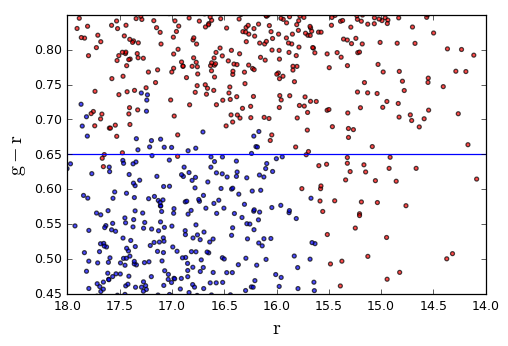

In [58]:
plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=10)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0.45,0.85)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

Create a colored map of predicted labels. Red color corresponds to points that have more than 75% probability of belonging to the red class, blue color corresponds to points that have more than 75% probability of belonging to the blue class. Green color marks the intermediate region where the classification is not as clear. 

[]

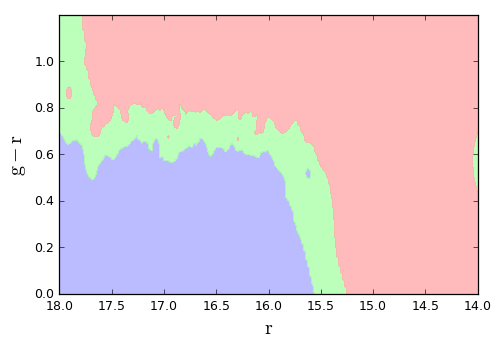

In [59]:
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light, levels=[0, 0.25, 0.75, 1])
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

### Support Vector Machines

[Support vector machines](http://scikit-learn.org/stable/modules/svm.html) (SVMs) are a set of supervised learning methods. SVMs draw a boundary between clusters of data, which maximizes the perpendicular distance between the clusters.

Sklearn implementation of the [SVM Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) has many options. One of the most important is choosing the kernel. Default choice is 'rbf', while 'linear' is very intuitive: it draws a straight line separating the clusters.

[]

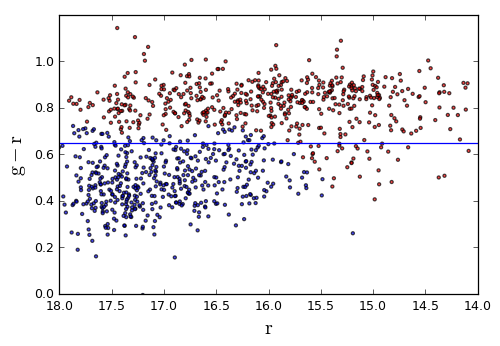

In [60]:
#clf = svm.SVC(gamma=2, kernel='linear')
clf = svm.SVC(gamma=2, kernel='rbf')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

[]

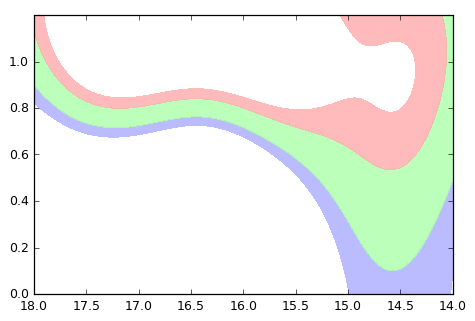

In [61]:
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light, levels=[0, 0.25, 0.75, 1])
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.plot()

### Random Forest

The [Random Forest](http://scikit-learn.org/stable/modules/ensemble.html#forest) is a type of the decision tree algorithm.

Sklearn implementation of the [RF Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) also has many parameters, one of the most important is the number of estimators.

[]

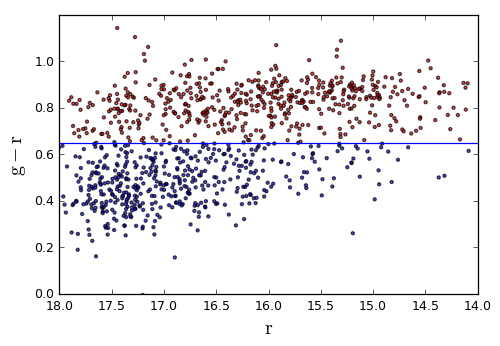

In [66]:
clf = ensemble.RandomForestClassifier(n_estimators=10)

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

[]

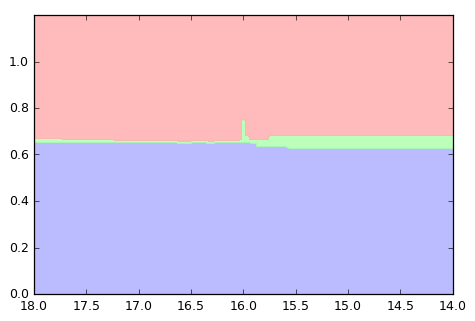

In [67]:
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light, levels=[0, 0.25, 0.75, 1])
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.plot()

**Exercise:** experiment with changing the parameters of all the methods above and find the ones that appear to make the best split for our dataset.

### Using additional information

Now let's see how the performance of the classifiers changes after we include additional information about our objects.  Add the $u-i$ color and repeat the selection of the training and test sets.

In [68]:
ui = data['modelMag_u'] - data['modelMag_i']

X = np.vstack([r, gr, ui]).T
print 'total dataset:', X.shape, 'galaxies'

Xtraining = X[:100]
print 'training set:', len(Xtraining), 'galaxies'

Xtest = X[-1000:]
print 'test set:', len(Xtest), 'galaxies'

total dataset: (114527L, 3L) galaxies
training set: 100 galaxies
test set: 1000 galaxies


[]

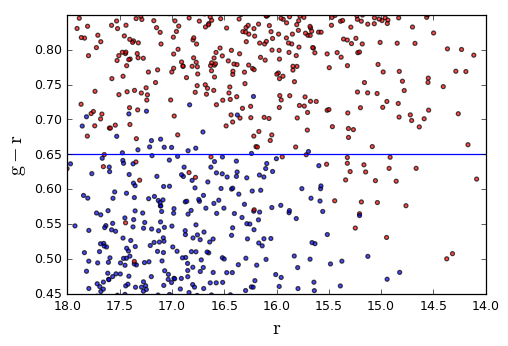

In [73]:
clf = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=10)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0.45,0.85)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

This close-up plot is different from its version above that used only two galaxy properties. Having even one additional color measurement has reduced the abundance of red objects in the lower right part of the plot.

In general, all available information should be included to make a more robust and reliable classification.